In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import math

#### Choose a Device

In [2]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Transformer Definition

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [5]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [8]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(device)
        tgt_mask = (tgt_mask & nopeak_mask).to(device)
        return src_mask, tgt_mask


    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
    
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output).to(device)
        return output

### Preprocess Text

In [9]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('../Data/shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


### Process Data

In [10]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), dtype = torch.long)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char) + 1
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_index(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]) # Target is represented in index.
    return input, target

### Instantiate Model

In [11]:
# Instantiate the Transformer model
d_model = 128
num_heads = 4
num_layers = 4
d_ff = 512
max_seq_length = 128
dropout = 0.1

model = Transformer(
    src_vocab_size=100,
    tgt_vocab_size=100,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    max_seq_length=max_seq_length,
    dropout=dropout
)
model.to(device)

Transformer(
  (encoder_embedding): Embedding(100, 128)
  (decoder_embedding): Embedding(100, 128)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=128, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-3): 4 x DecoderLayer(
     

### Generate Text

In [12]:
def generate_text(model,target,start_seq='W', gen_len=10,temperature=1.0):
    model.eval()  # Set the model to evaluation mode
    
    indices = ""
    tensor = start_seq[0]
    for char in tensor:
        indices += all_chars[char-1] 
        
    input_seq = start_seq
    
    for _ in range(gen_len):
        with torch.no_grad():
            output = model(input_seq, target)
        
        # Get the last output and convert to probabilities
        next_char_logits = output[-1, 0, :] # Shape: (output_dim)
        next_char_probs = torch.softmax(next_char_logits, dim=-1)/temperature

        predicted_char_index = torch.argmax(next_char_probs)
        predicted_char = all_chars[predicted_char_index]
        
        indices += predicted_char
        
        # Append the next character to the input sequence
        next_char_tensor = torch.tensor([predicted_char_index], dtype=torch.long).unsqueeze(1).to(device)
        input_seq = torch.cat([input_seq, next_char_tensor], dim=1)[:, 1:]
    
    return indices

### Training Procedure

In [13]:
# Number of iterations.
iters       = 20000
# Number of printing iterations
print_iters = 200   

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    opt.zero_grad()
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    input = input[None] 
    target = target[None] 
    predicted = model(input,target)
    predicted = predicted.permute(0,2,1)
    loss = loss_func(predicted,target)
    
    loss.backward()
    loss_sum += loss.item()                                # Accumulate the loss.
    opt.step()

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(generate_text(model,target,input)))

              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:199/20000 loss:0.2270066896174103
generated sequence: ted their foul ends.
In few, they hurried us aboard a bark,
Bore us some leagues to sea; where they prepared
A rotten carcass offfffffffff

iter:399/20000 loss:0.00483803846524097
generated sequence:  part in't
You chose her; then I'ld shriek, that even your ears
Should rift to hear me; and the words that follow'd
Should be 'Rqqqqqqqqqq

iter:599/20000 loss:0.0018016745737986638
generated sequence: he swoon? use means for her recovery.

GLOUCESTER:
Clarence, excuse me to the king my brother;
I'll hence to London on a seriousffffffffff

iter:799/20000 loss:0.0012054549128515646
generated sequence:  my girl:
By foul play, as thou say'st, were we heaved thence,
But blessedly holp hither.

MIRANDA:
O, my heart bleeds
To think nnnnnnnnnn

iter:999/20000 loss:0.0007715856087452266
generated sequence: base
To stain the temper of my knightly sword.

HENRY BOLINGBROKE:
Bagot, forbear; thou shalt not take it up.

DUKE OF AUMERLE:
bbbbbbb

iter:8399/20000 loss:3.578010422643274e-05
generated sequence:  do not give us the lie.

Clown:
Your worship had like to have given us one, if you
had not taken yourself with the manner.

Sheeeeeeeeeee

iter:8599/20000 loss:3.554983356480079e-05
generated sequence: at does appear as he were flay'd? O gods
He has the stamp of Marcius; and I have
Before-time seen him thus.

MARCIUS:

COMINIUS:uuuuuuuuuu

iter:8799/20000 loss:3.1250139345502246e-05
generated sequence: ory sits on our helms.

CATESBY:
Rescue, my Lord of Norfolk, rescue, rescue!
The king enacts more wonders than a man,
Daring an ssssssssss

iter:8999/20000 loss:2.8441989970815486e-05
generated sequence: her some: why, 'tis a happy thing
To be the father unto many sons.
Answer no more, for thou shalt be my queen.

GLOUCESTER:

CLAffffffffff

iter:9199/20000 loss:2.605177839541284e-05
generated sequence: your leave,
I am an officer of state, and come
To speak with Coriolanus.

First Senator:
From whence?

MENENIUS:
From Rome.

generated sequence: other's death,
And shall the same give pardon to a slave?
My brother slew no man; his fault was thought,
And yet his punishment uuuuuuuuuu

iter:16599/20000 loss:6.986866358715815e-07
generated sequence: rk: I'll not be long before
I call upon thee.

Mariner:
Make your best haste, and go not
Too far i' the land: 'tis like to be lollllllllll

iter:16799/20000 loss:6.32231703434627e-07
generated sequence: r be it from my heart, the thought of it!

QUEEN ELIZABETH:
As little joy, my lord, as you suppose
You should enjoy, were you th										

iter:16999/20000 loss:5.66112958750864e-07
generated sequence: th
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.

Second Citizeiiiiiiiiii

iter:17199/20000 loss:5.166549640023277e-07
generated sequence: a low submissive reverence
Say 'What is it your honour will command?'
Let one attend him with a silver basin
Full of rose-water 										

iter:17399/20000 loss:4.52

#### Training Loss Curve

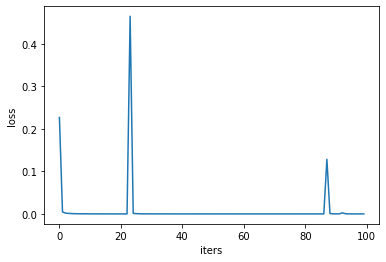

In [14]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.array(all_losses))
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [19]:
rand_input, rand_target = get_input_and_target()  
rand_input = rand_input[None].to(device)
rand_target = rand_target[None].to(device)
print("\n")
generate_text(model,target,input,gen_len=500)

'gain.\n\nROMEO:\nAlive, in triumph! and Mercutio slain!\nAway to heaven, respective lenity,\nAnd fire-eyed fury be my conduct now!\nNobbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb'